<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisCuantitativoAvanzado/blob/main/SeriesdeTiempo/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo ARIMA

La primera parte es toda igual.

Primero importamos todas las librerías necesarias, solo que esta vez incluimos la librería statsmodels

In [69]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels

import matplotlib.pyplot as plt

In [70]:
# Leemos y definimos la API key
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

user_key = api_token["key"]

Mounted at /content/drive


Obsérvese que tomamos la serie sin estacionalidad, en vez de la serie original.

In [71]:
# EMAE
emae = requests.get('https://api.alphacast.io/datasets/5331/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('emae.csv','wb').write(emae.content)
emae = pd.read_csv('emae.csv',delimiter = ',')

emae['Date'] = pd.to_datetime(emae['Date'])
emae.set_index('Date', inplace = True)

emae = emae['Emae - sa_orig - current_prices_mom']
emae.columns = ['Emae - sa_orig - current_prices_mom']
emae = emae.loc['2016-02-01':]

base['emae']=emae

In [72]:
# IPI
ipi = requests.get('https://api.alphacast.io/datasets/5679/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('ipi.csv','wb').write(ipi.content)
ipi = pd.read_csv('ipi.csv',delimiter = ',')


ipi['Date'] = pd.to_datetime(ipi['Date'])
ipi.set_index('Date', inplace = True)
ipi = ipi[(ipi['Division'] == "IPI Manufacturero") & (ipi['Seasonal Adjustment'] == "Seasonally Adjusted")]
ipi = ipi['Value - sa_MoM']
ipi.columns = ['Value - sa_MoM']
ipi = ipi.loc['2016-02-01':]

In [73]:
# ISAC
isac = requests.get('https://api.alphacast.io/datasets/5565/data?apiKey='+user_key+'&&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('isac.csv','wb').write(isac.content)
isac = pd.read_csv('isac.csv',delimiter = ',')


isac['Date'] = pd.to_datetime(isac['Date'])
isac.set_index('Date', inplace = True)
isac = isac['Nivel general - sa_MoM']
isac.columns = ['Nivel general - sa_MoM']
isac = isac.loc['2016-02-01':]

Preparamos una función para graficar

In [74]:
sns.set_theme(style='darkgrid')
def graficar(variable):
    fig = sns.lineplot(x=variable.index, y=variable)
    plt.title(variable.name)
    plt.xlabel("Año")
    plt.savefig('%s.png'%variable.name)
    return fig

Y la graficamos. ¿Es estacionaria? No confundir estacional con estacionaria

<Axes: title={'center': 'Emae - sa_orig - current_prices_mom'}, xlabel='Año', ylabel='Emae - sa_orig - current_prices_mom'>

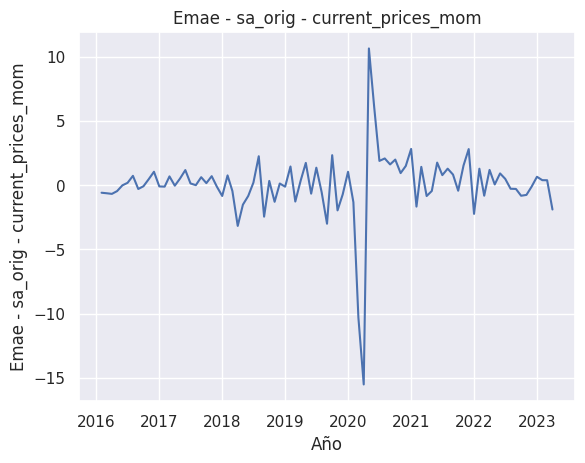

In [75]:
graficar(emae)

<Axes: title={'center': 'Value - sa_MoM'}, xlabel='Año', ylabel='Value - sa_MoM'>

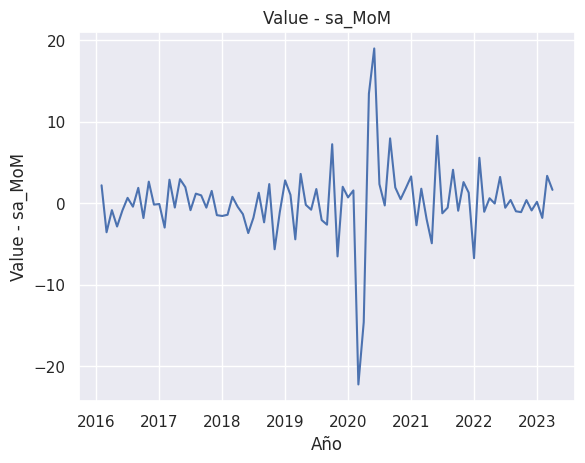

In [76]:
graficar(ipi)

<Axes: title={'center': 'Nivel general - sa_MoM'}, xlabel='Año', ylabel='Nivel general - sa_MoM'>

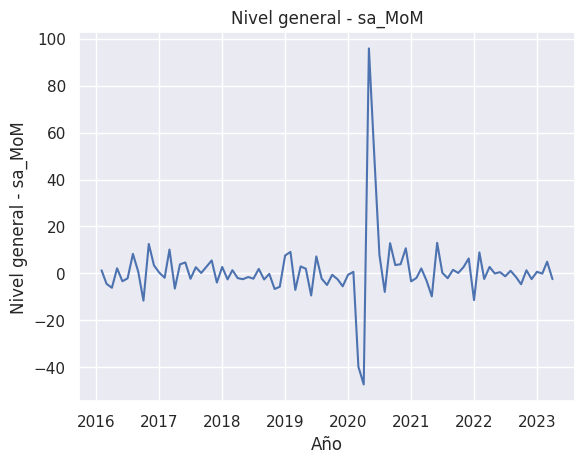

In [77]:
graficar(isac)

Chequeamos si la serie es estacionaria con el test de Dickey-Fuller aumentado del paquete Statsmodels.

La H0 del modelo es que la serie tiene raíz unitaria, es decir que no es estacionaria.

El p-value para los tres casos es <= 0.05 quiere decir que se puede rechazar la H0 y por tanto se asume que la serie es estacionaria. ¿Por qué? Ayuda: trajimos las series en diferencias.

In [78]:
from statsmodels.tsa.stattools import adfuller
res=adfuller(ipi)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.335032
p-value: 0.000000
Critical Values:
	1%: -3.510
	5%: -2.896
	10%: -2.585


# Modelo simple con StatsModel

In [79]:
frame = { 'EMAE': emae, 'IPI': ipi , 'ISAC': isac}
df = pd.DataFrame(frame)

In [80]:
results = smf.ols('EMAE ~ IPI + ISAC', data=df).fit()

In [81]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   EMAE   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     123.5
Date:                Thu, 06 Jul 2023   Prob (F-statistic):           9.61e-26
Time:                        17:53:11   Log-Likelihood:                -149.51
No. Observations:                  87   AIC:                             305.0
Df Residuals:                      84   BIC:                             312.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0798      0.148     -0.540      0.5

In [82]:
X =  pd.DataFrame({'IPI': [df['IPI'][-1]], 'ISAC': [df['ISAC'][-1]]})

In [83]:
print(results.predict(X)[0])

0.11649272143649173


In [84]:
df[-5:]

,EMAE,IPI,ISAC
Date,,,
2022-12-01,-0.124006,-0.904394,-2.443916
2023-01-01,0.641917,0.153096,0.682766
2023-02-01,0.379197,-1.822844,-0.096750
2023-03-01,0.373640,3.339814,4.985331
2023-04-01,-1.903896,1.618051,-2.449671


# Modelo ARIMA

In [85]:
from statsmodels.tsa.arima.model import ARIMA

In [90]:
df.EMAE[:-1]

Date
2016-02-01   -0.598232
2016-03-01   -0.637958
2016-04-01   -0.687110
2016-05-01   -0.472993
2016-06-01   -0.021763
                ...   
2022-11-01   -0.767813
2022-12-01   -0.124006
2023-01-01    0.641917
2023-02-01    0.379197
2023-03-01    0.373640
Name: EMAE, Length: 86, dtype: float64

In [128]:
mod = ARIMA(df.EMAE , order=(1, 0, 1))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   EMAE   No. Observations:                   87
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -206.928
Date:                Thu, 06 Jul 2023   AIC                            421.855
Time:                        18:23:48   BIC                            431.719
Sample:                    02-01-2016   HQIC                           425.827
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0316      0.514      0.062      0.951      -0.975       1.039
ar.L1         -0.5236      0.254     -2.058      0.040      -1.022      -0.025
ma.L1          0.7194      0.247      2.907      0.0

# Predicción

In [135]:
X = df['EMAE'].loc['2016-02-01':]
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [136]:
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,0,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=-0.335348, expected=1.522233
predicted=0.344261, expected=2.799583
predicted=0.124191, expected=-2.243438
predicted=-1.060302, expected=1.270186
predicted=0.791141, expected=-0.830820
predicted=-0.537164, expected=1.177524
predicted=0.555349, expected=0.046088
predicted=-0.262605, expected=0.903852
predicted=0.210147, expected=0.480176
predicted=-0.109448, expected=-0.288357
predicted=-0.091479, expected=-0.302740
predicted=0.064126, expected=-0.832958
predicted=0.009276, expected=-0.767813
predicted=0.169305, expected=-0.124006
predicted=0.254303, expected=0.641917
predicted=0.236172, expected=0.379197
predicted=0.001533, expected=0.373640
predicted=0.028058, expected=-1.903896


In [137]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.362


In [138]:
import numpy as np
df['prediction'] = np.nan
df.iloc[-len(predictions):, df.columns.get_loc('prediction')] = predictions

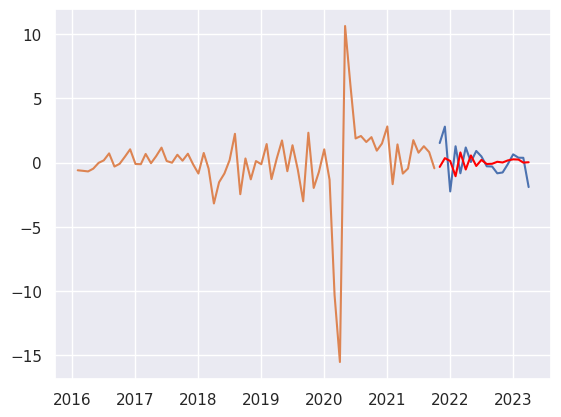

In [139]:
from matplotlib import pyplot
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(train)
pyplot.plot(df['prediction'], color='red')
pyplot.show()